In [1]:
import torch.nn as nn
import pandas as pd
import json
import os
import numpy as np
import pickle
import json
import scipy
from torch.utils.data import Dataset, DataLoader
import torch
from collections import defaultdict
import time
# import matplotlib.pyplot as plt
# import seaborn as sns
from datetime import timedelta

# define random seeds for Neural Networks
torch.manual_seed(0)
np.random.seed(0)

# ignore warnings jupyter notebook
import warnings
warnings.filterwarnings('ignore')


# importing from daads
import sys
sys.path.insert(0, '/Users/himanshu/Master_Thesis/code/OWRI/DAADS')
from tools.evaluate import aggregate_dataframe, test_then_train

# ========== FUNCTION ==============

In [2]:
# prepare input for AEs, 
# input is combined list of all intersections (vector -> [fpds + hourofday+ weekofday + intersectoion]) for each week and each hour sorted based on time
# output is -> list of feature vector and time for all interctions combined --> [[fpds + hourofday+ weekofday + intersectoion], time]
def prepare_input_for_PWAE(intersection_data):
    combined_fpds_for_AEs = []
    for i in range(7):
        for j in range(24):
            for fpd,time_instance in zip(intersection_data[i][j][0],intersection_data[i][j][1]):
                temp = fpd.astype(np.float32).tolist()
                temp.extend([time_instance, 0])
                combined_fpds_for_AEs.append(temp)

    # combined_fpds_for_AEs = sorted(combined_fpds_for_AEs, key=lambda x:x[12])
    return combined_fpds_for_AEs

In [3]:
# function to load data from pickle file
def load_pickle(filename):
    with open(filename, 'rb') as f:
        data = pickle.load(f)
    return data

In [19]:
# function to save outlier results
def save_outlier_results(outlier_results, path):
    outlier_df = pd.DataFrame(outlier_results,columns=["outlier_score",'timestamp']) # convert to dataframe
    outlier_df['timestamp'] = pd.to_datetime(outlier_df['timestamp']) # convert timestamp to datetime
    outlier_df.set_index('timestamp',inplace=True) # set timestamp as index
    outlier_df.to_csv(path) # save to csv

# =========== MAIN ===========

In [37]:
# DAADS MODELS = ["AE", "DAE","PW-AE"]
MODELS = ["AE", "DAE", "HST", "PW-AE", "xStream", "Kit-Net", "ILOF"]
# MODELS = ["xStream", "Kit-Net", "ILOF"]
CONFIGS = {
    "AE": {"lr": 0.02, "latent_dim": 0.1},
    "DAE": {"lr": 0.02},
    "PW-AE": {"lr": 0.1},
    "OC-SVM": {},
    "HST": {"n_trees": 25, "height": 15},
}

In [42]:
# load config file
with open('../utils/configs.json') as f:
    config = json.load(f)

#### ---------------------------- hauge AE processing ---------------------------- 

In [43]:
# declare variable and load data from pickle file
data_name = "hauge"
load_fpds_path = f"../data/{data_name}/processed/featured_fpds_raw.pickle"
model_save_path = f"../results/{data_name}/outlier_scores/{AE_model}"
featured_fpds = load_pickle(load_fpds_path)

In [44]:
for model_name in MODELS:

    print(f"processing model - {model_name} ")
    AE_model = model_name
    data_name = "hauge"
    load_fpds_path = f"../data/{data_name}/processed/featured_fpds_raw.pickle"
    featured_fpds = load_pickle(load_fpds_path)
    model_save_path = f"../results/{data_name}/outlier_scores/{AE_model}"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    time_list = []
    # for each trajectory, direction and intersection, run AE model
    for trajectory in config['trajectories']:
        for direction in config['trajectories'][trajectory]:
            for intersection in config['trajectories'][trajectory][direction]:
                # print trajectory, direction, intersection
                print(f"processing trajectory - {trajectory},  direction - {direction}, and intersection - {intersection} ")
                intersection_data = featured_fpds[trajectory][direction]['fpds'][intersection]
                intersection_data_flatten = prepare_input_for_PWAE(intersection_data) # flatten data
                df = pd.DataFrame(intersection_data_flatten, columns=['var'+str(i) for i in range(1, 13)]+['timestamp','Isanomaly']) # convert to dataframe
                train_data = df[['var'+str(i) for i in range(1, 13)]].to_dict('records') # convert to dict
                df = df.sort_values(by='timestamp')
                scores,total_time = test_then_train(train_data, dataset='OWRI',model=AE_model,seed=42,**CONFIGS.get(AE_model, {}))
                time_list.append(total_time/len(train_data))
                outlier_results = [[x,y] for x,y in zip(scores, df['timestamp'].to_list())]
                # save outlier scores to csv
                AE_score_save_path = os.path.join(model_save_path,f"{intersection}_{direction}.csv") # path to save outlier scores
                save_outlier_results(outlier_results, AE_score_save_path)
                # print(f"{intersection} done!")
                print('-----------------------------------------------')


    # save time to txt file
    time_save_path = os.path.join(model_save_path,'instance_train_time_seconds.txt') # path to save time
    with open(time_save_path, 'w') as f:
        f.write(str(time_list))

processing model - AE 
processing trajectory - T1,  direction - North, and intersection - K502 


100%|██████████| 19728/19728 [00:01<00:00, 11679.92it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K504 


100%|██████████| 19728/19728 [00:01<00:00, 11548.78it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K503 


100%|██████████| 19728/19728 [00:01<00:00, 12009.90it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K263 


100%|██████████| 19728/19728 [00:01<00:00, 11602.36it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K556 


100%|██████████| 19728/19728 [00:01<00:00, 11448.80it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K557 


100%|██████████| 19728/19728 [00:01<00:00, 11534.67it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K559 


100%|██████████| 19728/19728 [00:01<00:00, 11613.09it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K561 


100%|██████████| 19728/19728 [00:01<00:00, 10808.24it/s]


-----------------------------------------------
processing trajectory - T1,  direction - North, and intersection - K198 


100%|██████████| 19728/19728 [00:01<00:00, 11645.53it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K502 


100%|██████████| 19728/19728 [00:01<00:00, 11422.05it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K504 


100%|██████████| 19728/19728 [00:01<00:00, 11623.67it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K503 


100%|██████████| 19728/19728 [00:01<00:00, 11514.59it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K263 


100%|██████████| 19728/19728 [00:01<00:00, 11578.18it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K556 


100%|██████████| 19728/19728 [00:01<00:00, 11486.65it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K557 


100%|██████████| 19728/19728 [00:01<00:00, 11299.38it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K559 


100%|██████████| 19728/19728 [00:01<00:00, 11797.16it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K561 


100%|██████████| 19728/19728 [00:01<00:00, 11458.95it/s]


-----------------------------------------------
processing trajectory - T1,  direction - South, and intersection - K198 


100%|██████████| 19728/19728 [00:01<00:00, 11134.82it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K704 


100%|██████████| 19728/19728 [00:01<00:00, 11802.35it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K702 


100%|██████████| 19728/19728 [00:01<00:00, 11819.63it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K703 


100%|██████████| 19728/19728 [00:01<00:00, 11539.87it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K159 


100%|██████████| 19728/19728 [00:01<00:00, 11770.72it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K182 


100%|██████████| 19728/19728 [00:01<00:00, 11396.23it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K183 


100%|██████████| 19728/19728 [00:01<00:00, 11179.61it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K128 


100%|██████████| 19728/19728 [00:01<00:00, 11705.84it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K139 


100%|██████████| 19728/19728 [00:01<00:00, 11468.64it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K104 


100%|██████████| 19728/19728 [00:01<00:00, 11820.33it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K101 


100%|██████████| 19728/19728 [00:01<00:00, 11662.24it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K206 


100%|██████████| 19728/19728 [00:01<00:00, 11543.34it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K074 


100%|██████████| 19728/19728 [00:01<00:00, 11256.08it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K414 


100%|██████████| 19728/19728 [00:01<00:00, 11107.37it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K415 


100%|██████████| 19728/19728 [00:01<00:00, 11198.82it/s]


-----------------------------------------------
processing trajectory - T2,  direction - South, and intersection - K250 


100%|██████████| 19728/19728 [00:01<00:00, 11022.74it/s]


-----------------------------------------------
processing trajectory - T2,  direction - North, and intersection - K704 


100%|██████████| 19728/19728 [00:01<00:00, 11566.28it/s]


-----------------------------------------------
processing trajectory - T2,  direction - North, and intersection - K702 


100%|██████████| 19728/19728 [00:01<00:00, 10879.00it/s]


-----------------------------------------------
processing trajectory - T2,  direction - North, and intersection - K703 


 51%|█████     | 9965/19728 [00:00<00:00, 11365.53it/s]

#### ---------------------------- METR-LA AE processing ---------------------------- 

In [ ]:
# declare variable and load data from pickle file
data_name = "hauge"
load_fpds_path = f"../data/{data_name}/processed/featured_fpds_raw.pickle"
model_save_path = f"../results/{data_name}/outlier_scores/{AE_model}"
featured_fpds = load_pickle(load_fpds_path)

In [39]:
# AE for metr-la dataset
# an input vector is a 12-dimensional vector of the traffic data of the last 12 points (i.e., 5 minutes)

for model_name in MODELS:

    print(f"processing model - {model_name} ")
    AE_model = model_name
    data_name = "hauge"
    load_fpds_path = f"../data/{data_name}/processed/featured_fpds_raw.pickle"
    featured_fpds = load_pickle(load_fpds_path)
    model_save_path = f"../results/{data_name}/outlier_scores/{AE_model}"
    if not os.path.exists(model_save_path):
        os.makedirs(model_save_path)

    time_list = []
    for intersection in featured_fpds['fpds']:
        # print intersection
        # print(f"processing intersection - {intersection} ")
        intersection_data = featured_fpds['fpds'][intersection]
        intersection_data_flatten = prepare_input_for_PWAE(intersection_data) # flatten data
        df = pd.DataFrame(intersection_data_flatten, columns=['var'+str(i) for i in range(1, 13)]+['timestamp','Isanomaly']) # convert to dataframe
        train_data = df[['var'+str(i) for i in range(1, 13)]].to_dict('records') # convert to dict
        df = df.sort_values(by='timestamp')
        scores,total_time = test_then_train(train_data, dataset='OWRI',model=AE_model,seed=42,**CONFIGS.get(AE_model, {}))
        time_list.append(total_time/len(train_data))
        outlier_results = [[x,y] for x,y in zip(scores, df['timestamp'].to_list())]
        # save outlier scores to csv
        AE_score_save_path = os.path.join(model_save_path, intersection+'.csv') # path to save outlier scores
        save_outlier_results(outlier_results, AE_score_save_path)
        # print(f"{intersection} done!")
        print('-----------------------------------------------')


    # save time to txt file
    time_save_path = os.path.join(model_save_path,'instance_train_time_seconds.txt') # path to save time
    with open(time_save_path, 'w') as f:
        f.write(str(time_list))

processing model - AE 


KeyError: 'fpds'

# EXTRA

In [ ]:
df

In [82]:
direction = "North"
trajectory = "T1"
intersection = "K502"
intersection_data = featured_fpds[trajectory][direction][intersection]

In [83]:
# total numbe of data points
l = 0
for i in range(7):
    for j in range(24):
        l += len(intersection_data[i][j][0])
print(f"total number of data points for intersection - {intersection} is {l}")

total number of data points for intersection - K502 is 18653


In [84]:
# prepare input for AEs
intersection_data_flatten = prepare_input_for_AEs(intersection_data, intersection)

In [85]:
AE_dataset = AutoEncoderDataset(intersection_data_flatten)
AE_dataset.dim # feature vector dimension

23

In [86]:
train_dataloader = DataLoader(AE_dataset, batch_size=1, shuffle=False)
# train_dataloader = DataLoader(AE_dataset, batch_size=1, shuffle=False, collate_fn=my_collate)

In [87]:
# check if dataloader is working
for i in train_dataloader:
    print(i)
    break

[tensor([[0.0617, 0.0062, 0.0185, 0.0432, 0.0309, 0.0741, 0.0617, 0.1173, 0.1667,
         0.1543, 0.1667, 0.0988, 0.0417, 0.1429, 0.0000, 0.0000, 1.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000]]), ('2018-01-01 00:00:00',), ('K502',)]


In [96]:
# define model parameters
lr = 1e-2         # learning rate
w_d = 1e-5        # weight decay
epochs = 1
metrics = defaultdict(list)
outlier_loss = []
outlier_results = []
device = 'mps' if torch.backends.mps.is_available() else 'cpu'


In [97]:
model = AE(AE_dataset.dim)
model.to(device)
criterion = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=lr, weight_decay=w_d)

In [ ]:
# train model
start = time.time()
for epoch in range(epochs):
    ep_start = time.time()
    running_loss = 0.0
    for bx, data in enumerate(train_dataloader):
        bt = data[0]
        sensor_time = data[1][0]
        sample = model(bt.to(device))
        loss = criterion(bt.to(device), sample) # calculate loss for input and recreated output
        outlier_loss.append(loss.item()) # append loss to list
        outlier_results.append([loss.item(),sensor_time]) # append loss, time and intersection to list
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # # print average loss for every 25% batches
        # if bx % int(AE_dataset.__len__()/4) == 0:
        #     print('[EPOCH] {}/{}\t[BATCH] {}/{}\t[LOSS] {}'.format(epoch+1,epochs,bx+1,AE_dataset.__len__(),running_loss/(bx+1)))
    epoch_loss = running_loss/AE_dataset.__len__()
    metrics['train_loss'].append(epoch_loss)
    ep_end = time.time()
    print('-----------------------------------------------')
    print('[EPOCH] {}/{}\n[LOSS] {}'.format(epoch+1,epochs,epoch_loss))
    print('Epoch Complete in {}'.format(timedelta(seconds=ep_end-ep_start)))
end = time.time()
print('-----------------------------------------------')
print('[{} Training Completed: {}]'.format(intersection, timedelta(seconds=end-start)))

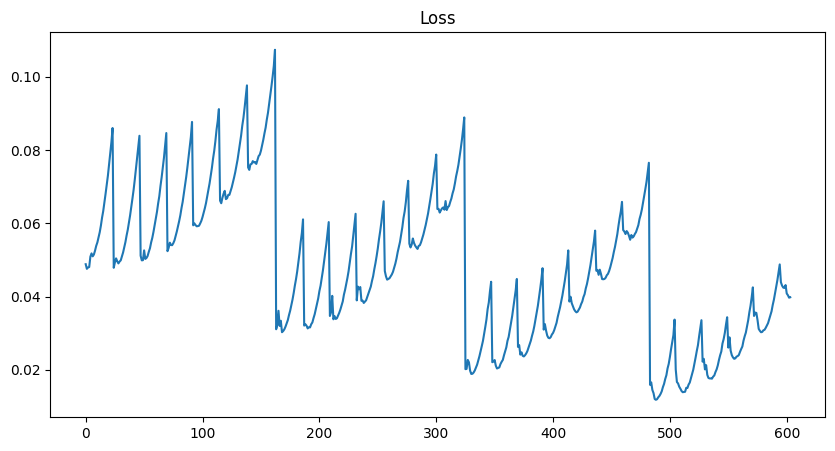

In [99]:
_, ax = plt.subplots(1,1,figsize=(10,5))
ax.set_title('Loss')
ax.plot(outlier_loss)

In [100]:
# get the top 5% of the loss values
top_5_percent = np.percentile(outlier_loss, 97)
top_5_percent

0.08599166825413702

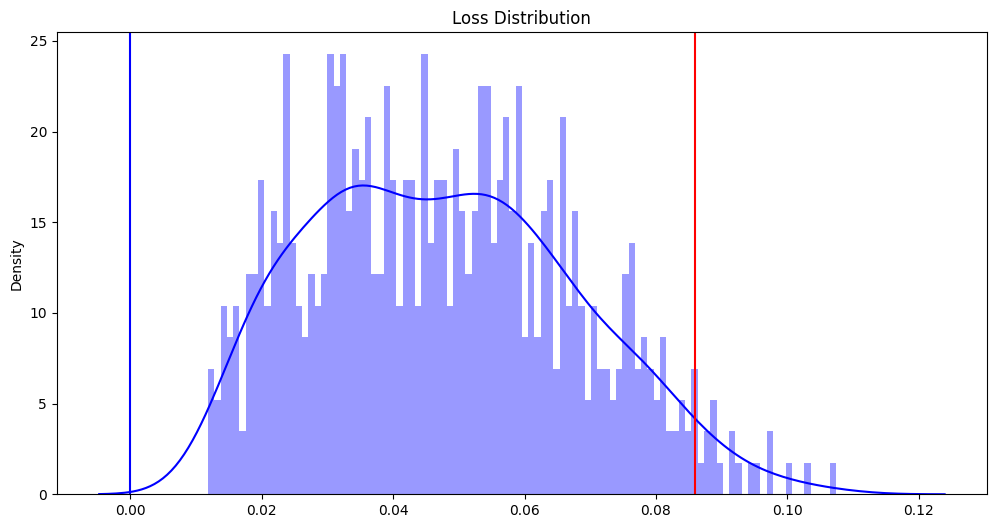

In [101]:
lower_threshold = 0.0
upper_threshold = top_5_percent
plt.figure(figsize=(12,6))
plt.title('Loss Distribution')
sns.distplot(outlier_loss,bins=100,kde=True, color='blue')
plt.axvline(upper_threshold, 0.0, 10, color='r')
plt.axvline(lower_threshold, 0.0, 10, color='b')

<Axes: >

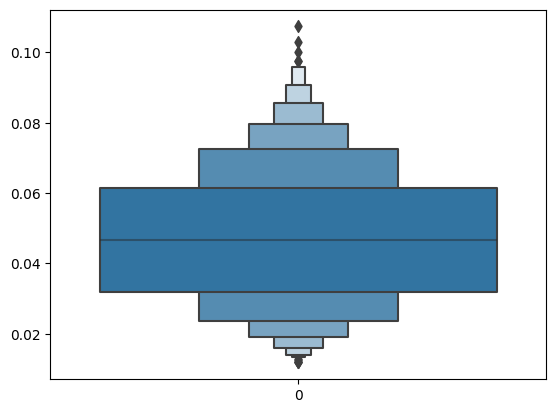

In [102]:
sns.boxenplot(outlier_loss)

In [103]:
outlier_df = pd.DataFrame(outlier_results,columns=[intersection,'timestamp'])
outlier_df.head()

,K502,timestamp
0,0.048843,2018-01-01 00:00:00
1,0.047579,2018-01-01 01:00:00
2,0.047945,2018-01-01 02:00:00
3,0.048071,2018-01-01 03:00:00
4,0.050888,2018-01-01 04:00:00


In [106]:
outlier_df['timestamp'] = pd.to_datetime(outlier_df['timestamp'])

In [107]:
# make timestamp as index
outlier_df.set_index('timestamp',inplace=True)

In [108]:
outlier_df

,K502
timestamp,
2018-01-01 00:00:00,0.048843
2018-01-01 01:00:00,0.047579
2018-01-01 02:00:00,0.047945
2018-01-01 03:00:00,0.048071
2018-01-01 04:00:00,0.050888
...,...
2018-01-27 04:00:00,0.043146
2018-01-27 05:00:00,0.040845
2018-01-27 06:00:00,0.040380


In [109]:
AE_score_save_path = f"../results/hauge/outlier_scores/AE/{intersection}.csv"

In [111]:
outlier_df.to_csv(AE_score_save_path)

In [105]:
type(outlier_df['timestamp'][0])

str

In [64]:
outlier_df['timestamp'] = outlier_df['timestamp'].apply(lambda x: x[0])
outlier_df['intersection'] = outlier_df['intersection'].apply(lambda x: x[0])

In [65]:
# create seperate columns for each intersection
outlier_df_intersection = outlier_df.pivot(index='timestamp', columns='intersection', values='loss')

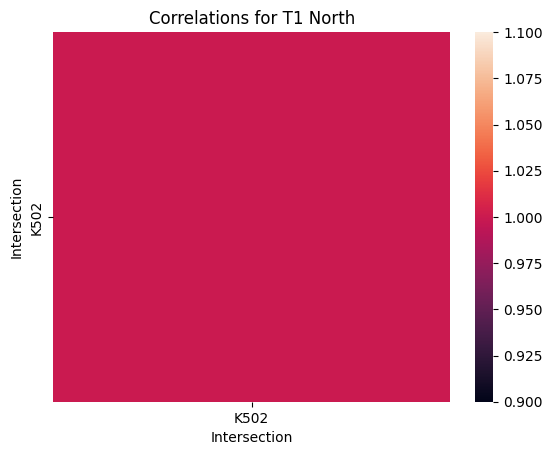

In [66]:
fig, ax = plt.subplots(facecolor='w')
sns.heatmap(outlier_df_intersection.corr())
plt.title("Correlations for T1 North")
plt.xlabel('Intersection')
plt.ylabel('Intersection')
plt.show()

In [89]:
corr_df = outlier_df_intersection.corr()
corr_df

intersection,K198,K263,K502,K503,K504,K556,K557,K559,K561
intersection,,,,,,,,,
K198,1.000000,0.858969,0.855700,0.876821,0.941535,0.878711,0.885909,0.862261,0.873933
K263,0.858969,1.000000,0.979711,0.955008,0.957613,0.966272,0.965140,0.981208,0.971364
K502,0.855700,0.979711,1.000000,0.954824,0.964305,0.970087,0.967824,0.983142,0.972013
K503,0.876821,0.955008,0.954824,1.000000,0.940753,0.969787,0.968760,0.951527,0.955668
K504,0.941535,0.957613,0.964305,0.940753,1.000000,0.954502,0.956067,0.960595,0.955847
K556,0.878711,0.966272,0.970087,0.969787,0.954502,1.000000,0.993521,0.973729,0.976356
K557,0.885909,0.965140,0.967824,0.968760,0.956067,0.993521,1.000000,0.973787,0.975118
K559,0.862261,0.981208,0.983142,0.951527,0.960595,0.973729,0.973787,1.000000,0.982927
K561,0.873933,0.971364,0.972013,0.955668,0.955847,0.976356,0.975118,0.982927,1.000000


### Comments over correlated intersections
- Except K198 all intersections are highly correlated
- hard to get the intution as the feature vector is - **[fpds + hourofday+ weekofday + intersectoion]**

In [91]:
# for each intersection, get the top 3 correlated intersections
top_3_corr = corr_df.apply(lambda x: x.sort_values(ascending=False).index[1:4], axis=1)
top_3_corr

intersection
K198    Index(['K504', 'K557', 'K556'], dtype='object'...
K263    Index(['K559', 'K502', 'K561'], dtype='object'...
K502    Index(['K559', 'K263', 'K561'], dtype='object'...
K503    Index(['K556', 'K557', 'K561'], dtype='object'...
K504    Index(['K502', 'K559', 'K263'], dtype='object'...
K556    Index(['K557', 'K561', 'K559'], dtype='object'...
K557    Index(['K556', 'K561', 'K559'], dtype='object'...
K559    Index(['K502', 'K561', 'K263'], dtype='object'...
K561    Index(['K559', 'K556', 'K557'], dtype='object'...
dtype: object